In [ ]:
import xarray as xr
import numpy as np
import pylab as plt
import cartopy.crs as ccrs
import cmocean
import copy as cp
from scipy.interpolate import griddata, interp1d
import pickle
import glob
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from matplotlib.cm import get_cmap
import cartopy as cr
import matplotlib.cm as cm
from datetime import datetime as dtime
import matplotlib.colors as colors

# Datas

## Subset ML

In [1]:
SUB_SETS = {'all':{'Subset_name':'/storage/nplanat/Glorys12_OP_journalier/NEW_RUN/Sub_samp_y_1993_-_2014_delta_1_100000_start_lon_0.nc',\
                  'init_year':1993,\
                  'final_year':2014,\
                   'delta_year':1,\
                  'N_particles':100000,\
                  'Subset_path':'/storage/nplanat/Glorys12_OP_journalier/NEW_RUN/'},\
           'weird_path_only':{'Subset_name':'/storage/nplanat/Glorys12_OP_journalier/WEIRD/Sub_samp_y_1996_-_1997_-delta_1_40000_start_lon_0.nc',\
                  'init_year':1996,\
                  'final_year':1997,\
                   'delta_year':1,\
                  'N_particles':40000,\
                  'Subset_path':'/storage/nplanat/Glorys12_OP_journalier/WEIRD/'},\
           'without_weird_path':{'Subset_name':None,\
                  'init_year':1993,\
                  'final_year':2014,\
                   'delta_year':1,\
                  'N_particles':100000,\
                  'Subset_path':'/storage/nplanat/Glorys12_OP_journalier/NO_WEIRD/'},\
           'all_short':{'Subset_name':'/storage/nplanat/Glorys12_OP_journalier/SHORT/Sub_samp_y_1993_-_2014_delta_1_100000_start_lon_0.nc',\
                  'init_year':1993,\
                  'final_year':2014,\
                   'delta_year':1,\
                  'N_particles':100000,\
                  'Subset_path':'/storage/nplanat/Glorys12_OP_journalier/SHORT/'}}

In [2]:
sel_subset = 'all'
load_previous_run = True
init_year = SUB_SETS[sel_subset]['init_year']
final_year = SUB_SETS[sel_subset]['final_year']
delta_year = SUB_SETS[sel_subset]['delta_year']
Subset_name = SUB_SETS[sel_subset]['Subset_name']
N_particles = SUB_SETS[sel_subset]['N_particles']
Subset_path = SUB_SETS[sel_subset]['Subset_path']

files = sorted(glob.glob('/storage/nplanat/Glorys12_OP_journalier/ADV_new_*'))
files_m = sorted(glob.glob('/storage/nplanat/Glorys12_OP_journalier/ADV_m_200_*'))
files_s = sorted(glob.glob('/storage/nplanat/Glorys12_OP_journalier/ADV_s_200_*'))
length_days = 600
path_save_prediction = Subset_path 


perctest = 0.1 
perctrain = 0.8
trans = True

#PCA 
n_components = 0.9999999

# Clustering
init = 'k-means++'
nmb_initialisations = 20  # number of initiatilisaton for the k-means++ 
max_iter = 500
tol = 5e-4
algorithm = 'full'
verbose = 0 
sample_weight = None
n_split = 20  # number of iterations for convergence
n_clusters = 20 #number of clusters

NameError: name 'glob' is not defined

In [ ]:
#load PCA : 
with open(Subset_path + 'pca.pkl', 'rb') as pickle_file:
    pca = pickle.load(pickle_file)
#load clustering : 
Traj_centroids = np.load(Subset_path+'Traj_centroids.npy', allow_pickle = True)
# load previous runs :
Labels_valid = np.load(path_save_prediction+'Labels_valid.npy')
Labels_test = np.load(path_save_prediction+'Labels_test.npy')
lats_test = np.load(path_save_prediction+'lats_test.npy')
lons_test = np.load(path_save_prediction+'lons_test.npy')
lats_train = np.load(path_save_prediction+'lats_train.npy')
lons_train = np.load(path_save_prediction+'lons_train.npy')
lats_valid = np.load(path_save_prediction+'lats_valid.npy')
lons_valid = np.load(path_save_prediction+'lons_valid.npy')

## Bathymetrie

In [12]:
def re_grid_fucking_ORCA(Aplot):
    # Make the new grid
    lons_1d=np.linspace(0, 360, 721)
    lats_1d=np.linspace(65, 90, 51)
    lons_2d, lats_2d = np.meshgrid(lons_1d, lats_1d)
    try:
        lons=Aplot.Lons_360.values
    except:
        lons = cp.deepcopy(Aplot.llon_cc.values)
        lons[lons<0] = lons[lons<0]+360
    try:
        lats=Aplot.llat_cc.values
    except:
        lats = Aplot.nav_lat.values
    temp=Aplot.values
    lons=lons.flatten()
    lats=lats.flatten()
    temp=temp.flatten()

    
    temp_new = griddata((lons, lats), temp, (lons_2d, lats_2d), method='linear')
    
    dint = xr.Dataset(data_vars = {'Lats_reg':lats_1d, 'Lons_reg_360':lons_1d})
    dint['val'] = (('Lats_reg', 'Lons_reg_360'), temp_new)
    return dint

In [13]:
# Load
ds_zgr =  xr.open_dataset('/storage/nplanat/Glorys12_masks/Mask_zgr_12.nc')
ds_zgr = ds_zgr.set_coords('nav_lat')
ds_zgr = ds_zgr.set_coords('nav_lon')
dsT = xr.open_dataset('/storage/nplanat/Glorys12_ORCA_mensuel/ext_arctic-GLORYS12V1_ORCA12_199408_gridT.nc')
dsT = dsT.set_coords('nav_lat')
dsT = dsT.set_coords('nav_lon')

Lons_360 = dsT.nav_lon.values
for x in range(dsT.nav_lon.shape[0]):
    for y in range(dsT.nav_lat.shape[1]):
        if Lons_360[x,y]<0:
            Lons_360[x,y] +=360
ds_zgr['Lons_360'] = (('y', 'x'), Lons_360)
ds_zgr = ds_zgr.set_coords('Lons_360')

bathy = re_grid_fucking_ORCA(ds_zgr.mbathy[0,:,:])

# Illustration

5305
4860
7120
6125
7242
8929
2325
4626
4431
5987


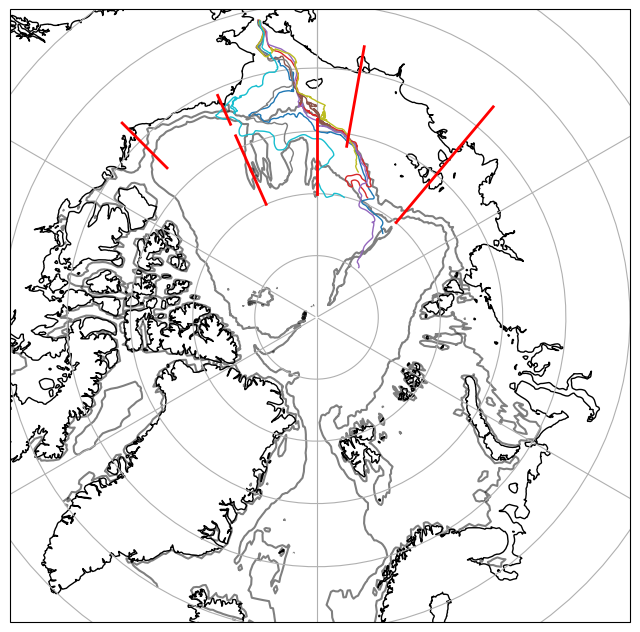

In [80]:
fig = plt.figure(figsize = (8, 8))
ax = fig.add_subplot(1,1,1,  projection = ccrs.NorthPolarStereo())
ax.coastlines()
ax.gridlines()
#ax.add_feature(cfeature.LAND)

for n in [np.random.randint(len(lats_valid)) for x in range(10)]:
    print(n)
    ax.plot(lons_valid[n], lats_valid[n],  transform=ccrs.PlateCarree(), lw = 1)
ax.set_extent([-200, 90, 65, 90], crs=ccrs.PlateCarree())
bathy.val.plot.contour(alpha = 0.5, levels = [38, 22], colors = 'k',ax=ax, transform=ccrs.PlateCarree(), x='Lons_reg_360', y='Lats_reg', add_colorbar=False,  infer_intervals=True)       

lo = -156
la_m = 70.5; la_M = 73
ax.plot(np.ones(50)*lo, np.linspace(la_m, la_M, 50),  transform=ccrs.PlateCarree(), c = 'r', lw = 2)

lo = -135
la_m = 68; la_M = 73
ax.plot(np.ones(50)*lo, np.linspace(la_m, la_M, 50),  transform=ccrs.PlateCarree(), c = 'r', lw = 2)

lo = 140
la_m = 68; la_M = 80
ax.plot(np.ones(50)*lo, np.linspace(la_m, la_M, 50),  transform=ccrs.PlateCarree(), c = 'r', lw = 2)

lo = 170
la_m = 68; la_M = 76
ax.plot(np.ones(50)*lo, np.linspace(la_m, la_M, 50),  transform=ccrs.PlateCarree(), c = 'r', lw = 2)

lo = -156
la_m = 74; la_M = 80
ax.plot(np.ones(50)*lo, np.linspace(la_m, la_M, 50),  transform=ccrs.PlateCarree(), c = 'r', lw = 2)

lo = 180
la_m = 74; la_M = 80
ax.plot(np.ones(50)*lo, np.linspace(la_m, la_M, 50),  transform=ccrs.PlateCarree(), c = 'r', lw = 2)

# Count through my 5 sections

In [212]:
def get_ind_sections(LAT, LON):
    L_ACC = []
    L_PB = []
    L_CB = []
    L_PB_CB = []
    L_EU = []
    L_SZ = []
    L_ESB = []
    L_PB_ESB = []
    for n in range(LAT.shape[0]):
        if np.any(np.logical_and(LON[n,:]>225,  LAT[n,:]<73)):
            L_ACC.append(n)
        if np.any(np.logical_and(np.logical_and(LON[n,:]>204, LON[n,:]<206), LAT[n,:]<73)):
            L_PB.append(n)
        if np.any(np.logical_and(np.logical_and(np.logical_and(LON[n,:]>202, LON[n,:]<204), LAT[n,:]>74), LAT[n,:]<80)) and LON[n,:][-1]>204:
            L_CB.append(n)
        if np.any(np.logical_and(np.logical_and(np.logical_and(LON[n,:]>202, LON[n,:]<204), LAT[n,:]>74), LAT[n,:]<80)) and LON[n,:][-1]>204 and np.any(np.logical_and(np.logical_and(LON[n,:]>204, LON[n,:]<206), LAT[n,:]<73)):
            L_PB_CB.append(n)

        if np.any(np.logical_and(np.logical_and(LON[n,:]>169, LON[n,:]<170), LAT[n,:]<76)):
            L_EU.append(n)

        if np.any(np.logical_and(np.logical_and(LON[n,:]>139, LON[n,:]<140), LAT[n,:]<80)):
            L_SZ.append(n)

        if np.any(np.logical_and(np.logical_and(np.logical_and(LON[n,:]>179, LON[n,:]<180), LAT[n,:]<80), LAT[n,:]>74)):
            L_ESB.append(n)
        if np.any(np.logical_and(np.logical_and(LON[n,:]>204, LON[n,:]<206), LAT[n,:]<73)) and np.any(np.logical_and(np.logical_and(np.logical_and(LON[n,:]>179, LON[n,:]<180), LAT[n,:]<80), LAT[n,:]>74)):
            L_PB_ESB.append(n)
    return L_ACC, L_PB, L_CB, L_PB_CB, L_EU, L_SZ, L_ESB, L_PB_ESB

In [205]:
L_ACC, L_PB, L_CB, L_PB_CB, L_EU, L_SZ, L_ESB, L_PB_ESB = get_ind_sections(lats_valid, lons_valid)

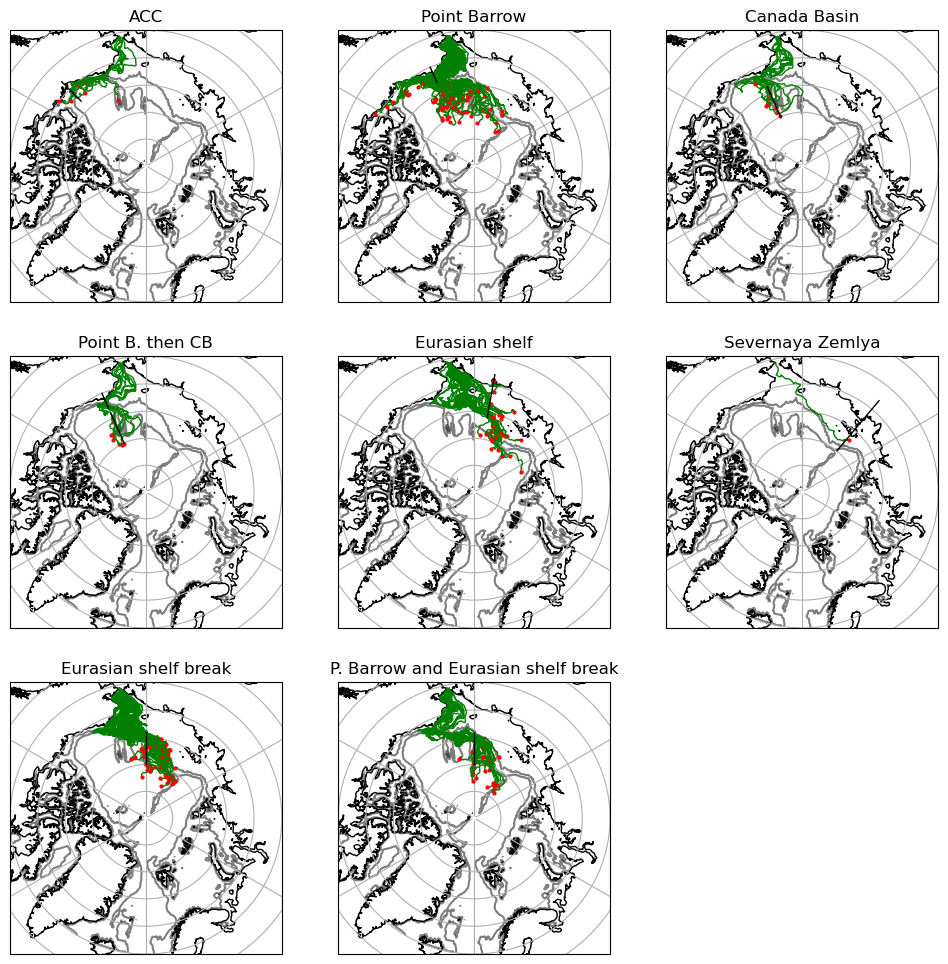

In [149]:
faster = 50

fig = plt.figure(figsize = (12,12))
ax = fig.add_subplot(3,3,1,  projection = ccrs.NorthPolarStereo())
ax.coastlines()
ax.gridlines()
ax.set_extent([-90, 180, 65, 75], crs=ccrs.PlateCarree())
bathy.val.plot.contour(alpha = 0.5, levels = [38, 22], colors = 'k',ax=ax, transform=ccrs.PlateCarree(), x='Lons_reg_360', y='Lats_reg', add_colorbar=False,  infer_intervals=True)       
for n in L_ACC[::faster]:
    ax.plot(lons_valid[n], lats_valid[n],  transform=ccrs.PlateCarree(), lw = 1, c = 'g')
    ax.plot(lons_valid[n][-1], lats_valid[n][-1],'r.', markersize = 4,  transform=ccrs.PlateCarree(), lw = 1)
ax.set_title('ACC')

lo = -135
la_m = 68; la_M = 73
ax.plot(np.ones(50)*lo, np.linspace(la_m, la_M, 50),  transform=ccrs.PlateCarree(), c = 'k', lw = 1)
#-------------------------------------------------------------------
ax = fig.add_subplot(3,3,2,  projection = ccrs.NorthPolarStereo())
ax.coastlines()
ax.gridlines()
ax.set_extent([-90, 180, 65, 75], crs=ccrs.PlateCarree())
bathy.val.plot.contour(alpha = 0.5, levels = [38, 22], colors = 'k',ax=ax, transform=ccrs.PlateCarree(), x='Lons_reg_360', y='Lats_reg', add_colorbar=False,  infer_intervals=True)       
for n in L_PB[::faster]:
    ax.plot(lons_valid[n], lats_valid[n],  transform=ccrs.PlateCarree(), lw = 1, c = 'g')
    ax.plot(lons_valid[n][-1], lats_valid[n][-1],'r.', markersize = 4, transform=ccrs.PlateCarree(), lw = 1)
ax.set_title('Point Barrow')

lo = -156
la_m = 70;la_M = 73
ax.plot(np.ones(50)*lo, np.linspace(la_m, la_M, 50),  transform=ccrs.PlateCarree(), c = 'k', lw = 1)
#-------------------------------------------------------------

ax = fig.add_subplot(3,3,3,  projection = ccrs.NorthPolarStereo())
ax.coastlines()
ax.gridlines()
ax.set_extent([-90, 180, 65, 75], crs=ccrs.PlateCarree())
bathy.val.plot.contour(alpha = 0.5, levels = [38, 22], colors = 'k',ax=ax, transform=ccrs.PlateCarree(), x='Lons_reg_360', y='Lats_reg', add_colorbar=False,  infer_intervals=True)       
for n in L_CB[::faster]:
    ax.plot(lons_valid[n], lats_valid[n],  transform=ccrs.PlateCarree(), lw = 1, c = 'g')
    ax.plot(lons_valid[n][-1], lats_valid[n][-1],'r.', markersize = 4, transform=ccrs.PlateCarree(), lw = 1)
ax.set_title('Canada Basin')


lo = -156
la_m = 74; la_M = 80
ax.plot(np.ones(50)*lo, np.linspace(la_m, la_M, 50),  transform=ccrs.PlateCarree(), c = 'k', lw = 1)

#---------------------------------------------------------------------


ax = fig.add_subplot(3,3,4,  projection = ccrs.NorthPolarStereo())
ax.coastlines()
ax.gridlines()
ax.set_extent([-90, 180, 65, 75], crs=ccrs.PlateCarree())
bathy.val.plot.contour(alpha = 0.5, levels = [38, 22], colors = 'k',ax=ax, transform=ccrs.PlateCarree(), x='Lons_reg_360', y='Lats_reg', add_colorbar=False,  infer_intervals=True)       
for n in L_PB_CB[::faster]:
    ax.plot(lons_valid[n], lats_valid[n],  transform=ccrs.PlateCarree(), lw = 1, c = 'g')
    ax.plot(lons_valid[n][-1], lats_valid[n][-1],'r.', markersize = 4, transform=ccrs.PlateCarree(), lw = 1)
ax.set_title('Point B. then CB')


lo = -156
la_m = 70;la_M = 73
ax.plot(np.ones(50)*lo, np.linspace(la_m, la_M, 50),  transform=ccrs.PlateCarree(), c = 'k', lw = 1)
lo = -156
la_m = 74; la_M = 80
ax.plot(np.ones(50)*lo, np.linspace(la_m, la_M, 50),  transform=ccrs.PlateCarree(), c = 'k', lw = 1)

#-------------------------------------------------------
ax = fig.add_subplot(3,3,5,  projection = ccrs.NorthPolarStereo())
ax.coastlines()
ax.gridlines()
ax.set_extent([-90, 180, 65, 75], crs=ccrs.PlateCarree())
bathy.val.plot.contour(alpha = 0.5, levels = [38, 22], colors = 'k',ax=ax, transform=ccrs.PlateCarree(), x='Lons_reg_360', y='Lats_reg', add_colorbar=False,  infer_intervals=True)       
for n in L_EU[::faster]:
    ax.plot(lons_valid[n], lats_valid[n],  transform=ccrs.PlateCarree(), lw = 1, c = 'g')
    ax.plot(lons_valid[n][-1], lats_valid[n][-1],'r.', markersize = 4, transform=ccrs.PlateCarree(), lw = 1)
ax.set_title('Eurasian shelf')

lo = 170
la_m = 68; la_M = 76
ax.plot(np.ones(50)*lo, np.linspace(la_m, la_M, 50),  transform=ccrs.PlateCarree(), c = 'k', lw = 1)

#-------------------------------------------------------
ax = fig.add_subplot(3,3,6,  projection = ccrs.NorthPolarStereo())
ax.coastlines()
ax.gridlines()
ax.set_extent([-90, 180, 65, 75], crs=ccrs.PlateCarree())
bathy.val.plot.contour(alpha = 0.5, levels = [38, 22], colors = 'k',ax=ax, transform=ccrs.PlateCarree(), x='Lons_reg_360', y='Lats_reg', add_colorbar=False,  infer_intervals=True)       
for n in L_SZ[::faster]:
    ax.plot(lons_valid[n], lats_valid[n],  transform=ccrs.PlateCarree(), lw = 1, c = 'g')
    ax.plot(lons_valid[n][-1], lats_valid[n][-1],'r.', markersize = 4,transform=ccrs.PlateCarree(), lw = 1)
ax.set_title('Severnaya Zemlya')

lo = 140
la_m = 68; la_M = 80
ax.plot(np.ones(50)*lo, np.linspace(la_m, la_M, 50),  transform=ccrs.PlateCarree(), c = 'k', lw = 1)

#---------------------------------------------------------------------
ax = fig.add_subplot(3,3,7,  projection = ccrs.NorthPolarStereo())
ax.coastlines()
ax.gridlines()
ax.set_extent([-90, 180, 65, 75], crs=ccrs.PlateCarree())
bathy.val.plot.contour(alpha = 0.5, levels = [38, 22], colors = 'k',ax=ax, transform=ccrs.PlateCarree(), x='Lons_reg_360', y='Lats_reg', add_colorbar=False,  infer_intervals=True)       
for n in L_ESB[::faster]:
    ax.plot(lons_valid[n], lats_valid[n],  transform=ccrs.PlateCarree(), lw = 1, c = 'g')
    ax.plot(lons_valid[n][-1], lats_valid[n][-1],'r.', markersize = 4, transform=ccrs.PlateCarree(), lw = 1)
ax.set_title('Eurasian shelf break')


lo = 180
la_m = 74; la_M = 80
ax.plot(np.ones(50)*lo, np.linspace(la_m, la_M, 50),  transform=ccrs.PlateCarree(), c = 'k', lw = 1)


#---------------------------------------------------------------------
ax = fig.add_subplot(3,3,8,  projection = ccrs.NorthPolarStereo())
ax.coastlines()
ax.gridlines()
ax.set_extent([-90, 180, 65, 75], crs=ccrs.PlateCarree())
bathy.val.plot.contour(alpha = 0.5, levels = [38, 22], colors = 'k',ax=ax, transform=ccrs.PlateCarree(), x='Lons_reg_360', y='Lats_reg', add_colorbar=False,  infer_intervals=True)       
for n in L_PB_ESB[::faster]:
    ax.plot(lons_valid[n], lats_valid[n],  transform=ccrs.PlateCarree(), lw = 1, c = 'g')
    ax.plot(lons_valid[n][-1], lats_valid[n][-1],'r.', markersize = 4, transform=ccrs.PlateCarree(), lw = 1)
ax.set_title('P. Barrow and Eurasian shelf break')


lo = 180
la_m = 74; la_M = 80
ax.plot(np.ones(50)*lo, np.linspace(la_m, la_M, 50),  transform=ccrs.PlateCarree(), c = 'k', lw = 1)


# Classic identification to all lats_lons

In [168]:
def running_mean(t, x, N) :
    rm = np.convolve(x, np.ones((N,))/N, mode='valid')
    times = t[int(N/2):len(rm)+int(N/2)]
    return times, rm

In [213]:
for yr in range(1993,2014):
    print('Year', yr)
    lat_yr = np.load('/storage/nplanat/Glorys12_OP_journalier/lats_lons/lats_%i'%yr+'.npy')
    lon_yr = np.load('/storage/nplanat/Glorys12_OP_journalier/lats_lons/lons_%i'%yr+'.npy')
    L_ACC, L_PB, L_CB, L_PB_CB, L_EU, L_SZ, L_ESB, L_PB_ESB = get_ind_sections(lat_yr, lon_yr)
    np.save('/storage/nplanat/Glorys12_OP_journalier/Classic/L_ACC_%i'%yr, L_ACC)
    np.save('/storage/nplanat/Glorys12_OP_journalier/Classic/L_PB_%i'%yr, L_PB)
    np.save('/storage/nplanat/Glorys12_OP_journalier/Classic/L_CB_%i'%yr, L_CB)
    np.save('/storage/nplanat/Glorys12_OP_journalier/Classic/L_PB_CB_%i'%yr, L_PB_CB)
    np.save('/storage/nplanat/Glorys12_OP_journalier/Classic/L_SZ_%i'%yr, L_SZ)
    np.save('/storage/nplanat/Glorys12_OP_journalier/Classic/L_ESB_%i'%yr, L_ESB)
    np.save('/storage/nplanat/Glorys12_OP_journalier/Classic/L_PB_ESB_%i'%yr, L_PB_ESB)
    np.save('/storage/nplanat/Glorys12_OP_journalier/Classic/L_EU_%i'%yr, L_EU)

Year 1993
Year 1994
Year 1995
Year 1996
Year 1997
Year 1998
Year 1999
Year 2000
Year 2001
Year 2002
Year 2003
Year 2004
Year 2005
Year 2006
Year 2007
Year 2008
Year 2009
Year 2010
Year 2011
Year 2012
Year 2013


In [225]:
def get_sections_classic():
    Dates_all = []; NMB_all = []; 
    for yr in range(1993,2014):
        L_ACC = np.load('/storage/nplanat/Glorys12_OP_journalier/Classic/L_ACC_%i'%yr+'.npy')
        L_PB = np.load('/storage/nplanat/Glorys12_OP_journalier/Classic/L_PB_%i'%yr+'.npy')
        L_CB =np.load('/storage/nplanat/Glorys12_OP_journalier/Classic/L_CB_%i'%yr+'.npy')
        L_PB_CB =np.load('/storage/nplanat/Glorys12_OP_journalier/Classic/L_PB_CB_%i'%yr+'.npy')
        L_SZ =np.load('/storage/nplanat/Glorys12_OP_journalier/Classic/L_SZ_%i'%yr+'.npy')
        L_ESB =np.load('/storage/nplanat/Glorys12_OP_journalier/Classic/L_ESB_%i'%yr+'.npy')
        L_PB_ESB =np.load('/storage/nplanat/Glorys12_OP_journalier/Classic/L_PB_ESB_%i'%yr+'.npy')
        L_EU =np.load('/storage/nplanat/Glorys12_OP_journalier/Classic/L_EU_%i'%yr+'.npy')
        time_yr = np.load('/storage/nplanat/Glorys12_OP_journalier/lats_lons/times_%i'%yr+'.npy', allow_pickle = True)
        Date_data = np.unique(time_yr)
        Dates_all.extend(Date_data)    
        NMB_courrant = np.zeros((len(Date_data), 9))
        
        labs_yr_ACC = np.zeros(len(time_yr))
        labs_yr_PB = np.zeros(len(time_yr))
        labs_yr_CB = np.zeros(len(time_yr))
        labs_yr_PB_CB = np.zeros(len(time_yr))
        labs_yr_ESB = np.zeros(len(time_yr))
        labs_yr_PB_ESB = np.zeros(len(time_yr))
        labs_yr_EU = np.zeros(len(time_yr))
        labs_yr_SZ = np.zeros(len(time_yr))
        
        labs_yr_ACC[np.array(L_ACC)] =1
        labs_yr_PB[np.array(L_PB)] =2
        labs_yr_CB[np.array(L_CB)] =3
        labs_yr_PB_CB[np.array(L_PB_CB)] =4
        try:
            labs_yr_SZ[np.array(L_SZ)] =5
        except:
            print('No SZ in '+str(yr))
        labs_yr_ESB[np.array(L_ESB)] =6
        labs_yr_EU[np.array(L_EU)] =7
        labs_yr_PB_ESB[np.array(L_PB_ESB)] =8

        for i in range(len(Date_data)):
            d0 = np.where(Date_data[i] ==time_yr)[0]
            for di in d0:
                NMB_courrant[i,int(labs_yr_ACC[di])] +=1
                NMB_courrant[i,int(labs_yr_PB[di])] +=1
                NMB_courrant[i,int(labs_yr_CB[di])] +=1
                NMB_courrant[i,int(labs_yr_PB_CB[di])] +=1
                NMB_courrant[i,int(labs_yr_ESB[di])] +=1
                NMB_courrant[i,int(labs_yr_PB_ESB[di])] +=1
                NMB_courrant[i,int(labs_yr_EU[di])] +=1
                NMB_courrant[i,int(labs_yr_SZ[di])] +=1
                
            #NMB_courrant[i,:] =100*NMB_courrant[i,:]/len(d0)
        NMB_all.extend(NMB_courrant)
    NMB_all = np.array(NMB_all)
    return NMB_all, Dates_all

In [226]:
NMB_all, Dates_all = get_sections_classic()

No SZ in 1993
No SZ in 1994
No SZ in 1998


groupe,  1
groupe,  2
groupe,  3
groupe,  4
groupe,  5
groupe,  6
groupe,  7
groupe,  8


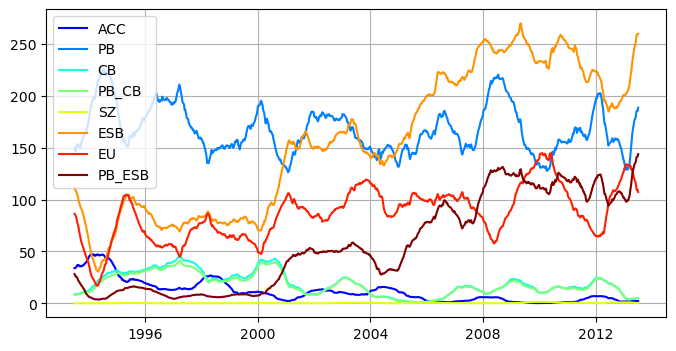

In [228]:
f = plt.figure(figsize = (8,4))
ax = f.add_subplot(1,1,1)
cmap = plt.cm.jet(np.linspace(0,1,9))
Names = ['-', 'ACC', 'PB', 'CB', 'PB_CB', 'SZ', 'ESB','EU', 'PB_ESB']
for i in range(1,9):
    print('groupe, ', i)
    tm0, rm = running_mean(Dates_all, NMB_all[:,i], 53)
    ax.plot(tm0, rm, label = Names[i], ls= '-', c = cmap[i])
ax.grid('on')
ax.legend(loc= 'upper left')
